In [1]:
import numpy as np 
import pandas as pd
import networkx as nx

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap as Basemap

In [5]:
# Read route data
route_cols = ['Airline', 'Airline ID', 'Source Airport', 'Source Airport ID',
              'Dest Airport', 'Dest Airport ID', 'Codeshare', 'Stops', 'equipment']
routes_df = pd.read_csv("../input/flight-route-database/routes.csv", skiprows=1, names = route_cols)

print(routes_df.shape)
routes_df.head()

(67663, 9)


,Airline,Airline ID,Source Airport,Source Airport ID,Dest Airport,Dest Airport ID,Codeshare,Stops,equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2


In [4]:
# Read airport data
airport_df = pd.read_csv("../input/openflights-airports-database-2017/airports.csv")

print(airport_df.shape)
airport_df.tail()

(7698, 14)


,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Database Timezone,Type,Source
7693,14106,Rogachyovo Air Base,Belaya,Russia,\N,ULDA,71.616699,52.478298,272,\N,\N,\N,airport,OurAirports
7694,14107,Ulan-Ude East Airport,Ulan Ude,Russia,\N,XIUW,51.849998,107.737999,1670,\N,\N,\N,airport,OurAirports
7695,14108,Krechevitsy Air Base,Novgorod,Russia,\N,ULLK,58.625000,31.385000,85,\N,\N,\N,airport,OurAirports
7696,14109,Desierto de Atacama Airport,Copiapo,Chile,CPO,SCAT,-27.261200,-70.779198,670,\N,\N,\N,airport,OurAirports
7697,14110,Melitopol Air Base,Melitopol,Ukraine,\N,UKDM,46.880001,35.305000,0,\N,\N,\N,airport,OurAirports


In [6]:
# Drop airport that don't have IATA data
airport_df = airport_df[airport_df.IATA != '\\N']

print(airport_df.shape)
airport_df.tail()

(6072, 14)


,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Database Timezone,Type,Source
7684,14097,Bilogai-Sugapa Airport,Sugapa-Papua Island,Indonesia,UGU,WABV,-3.739560,137.031998,7348,\N,\N,\N,airport,OurAirports
7687,14100,Ramon Airport,Eilat,Israel,ETM,LLER,29.723694,35.011416,288,\N,\N,\N,airport,OurAirports
7688,14101,Rustaq Airport,Al Masna'ah,Oman,MNH,OORQ,23.640556,57.487500,349,\N,\N,\N,airport,OurAirports
7689,14102,Laguindingan Airport,Cagayan de Oro City,Philippines,CGY,RPMY,8.612203,124.456496,190,\N,\N,\N,airport,OurAirports
7696,14109,Desierto de Atacama Airport,Copiapo,Chile,CPO,SCAT,-27.261200,-70.779198,670,\N,\N,\N,airport,OurAirports


In [7]:
airport_all = airport_df[['Name','City','Country','Latitude', 'Longitude', 'IATA', 'ICAO']]
IATA_array = airport_all["IATA"].tolist()

#all_airport_ix = airport_all.index.values
#routes_us = routes_df[(routes_df['Source Airport ID'].isin(us_airport_ix)) &
#                     (routes_df['Dest Airport ID'].isin(us_airport_ix))] #extract routes that flyies from AND to USA

# make new route df with route count
routes_all =  pd.DataFrame(routes_df.groupby(['Source Airport', 'Dest Airport']).size().reset_index(name='counts'))

In [8]:
print(routes_all.shape)
routes_all.head()

(37595, 3)


,Source Airport,Dest Airport,counts
0,AAE,ALG,1
1,AAE,CDG,1
2,AAE,IST,1
3,AAE,LYS,1
4,AAE,MRS,2


In [12]:
# only keep route with airport have IATA code
routes_all = routes_all[routes_all['Source Airport'].isin(IATA_array)]
routes_all = routes_all[routes_all['Dest Airport'].isin(IATA_array)]

In [14]:
# to find number of flights in and out of an airport
# it is similar to find number of rows in which each airport occur in either one of the 2 columns
counts = routes_all['Source Airport'].append(routes_all.loc[routes_all['Source Airport'] != routes_all['Dest Airport'], 'Dest Airport']).value_counts()

# create a data frame of position based on names in count
counts = pd.DataFrame({'IATA': counts.index, 'total_flight': counts})
pos_data = counts.merge(airport_all, on = 'IATA')

In [15]:
counts.head()

,IATA,total_flight
FRA,FRA,477
CDG,CDG,470
AMS,AMS,463
IST,IST,455
ATL,ATL,433


In [16]:
pos_data.head()

,IATA,total_flight,Name,City,Country,Latitude,Longitude,ICAO
0,FRA,477,Frankfurt am Main Airport,Frankfurt,Germany,50.033333,8.570556,EDDF
1,CDG,470,Charles de Gaulle International Airport,Paris,France,49.012798,2.550000,LFPG
2,AMS,463,Amsterdam Airport Schiphol,Amsterdam,Netherlands,52.308601,4.763890,EHAM
3,IST,455,Istanbul Airport,Istanbul,Turkey,41.275278,28.751944,LTFM
4,ATL,433,Hartsfield Jackson Atlanta International Airport,Atlanta,United States,33.636700,-84.428101,KATL


In [17]:
# Create graph
graph = nx.from_pandas_edgelist(routes_all, source = 'Source Airport', target = 'Dest Airport', edge_attr = 'counts',create_using = nx.DiGraph())
print(nx.info(graph))

Name: 
Type: DiGraph
Number of nodes: 3257
Number of edges: 37042
Average in degree:  11.3730
Average out degree:  11.3730


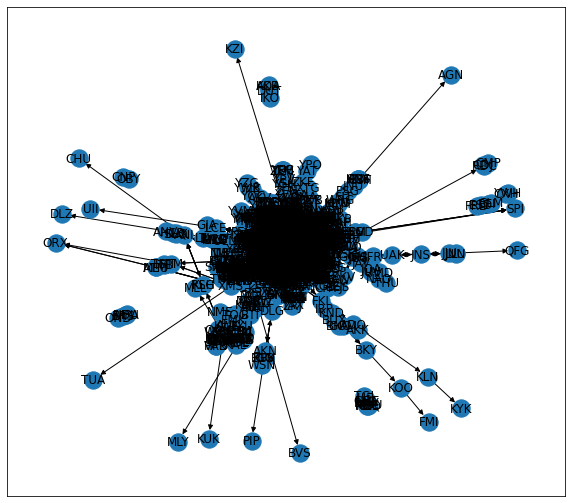

In [18]:
# default graph using Networkx inbuilt graph tools
plt.figure(figsize = (10,9))
nx.draw_networkx(graph)
plt.savefig("map_0.png", format = "png", dpi = 300)
plt.show()

<Figure size 1080x1440 with 0 Axes>

In [20]:
# import long lat as m attribute
mx, my = m(pos_data['Longitude'].values, pos_data['Latitude'].values)
pos = {}
for count, elem in enumerate (pos_data['IATA']):
    pos[elem] = (mx[count], my[count])

In [25]:
list(pos.items())[:5]

[('FRA', (20968079.268212434, 65991633.67017012)),
 ('CDG', (20298624.300668553, 65816812.28718153)),
 ('AMS', (20544797.520898663, 66395248.775533654)),
 ('IST', (23212146.169762805, 64594179.56020862)),
 ('ATL', (10627105.294453247, 63522473.74451846))]

In [86]:
# Set up base map
plt.figure(figsize=(40,40))
m = Basemap(projection='merc', resolution='l', suppress_ticks=True,
           lon_0=0
           )

<Figure size 2880x2880 with 0 Axes>

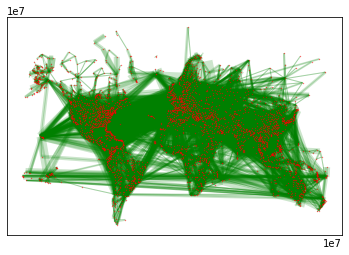

In [82]:
nx.draw_networkx_nodes(G = graph, pos = pos, node_list = graph.nodes(), node_color = 'r', alpha = 0.8,
                       node_size = 0.1)
nx.draw_networkx_edges(G = graph, pos = pos, edge_color='g', width = routes_all['counts'], 
                       alpha=0.2, arrows = False)
plt.savefig("map_1.png", format = "png", dpi = 300)
plt.show()

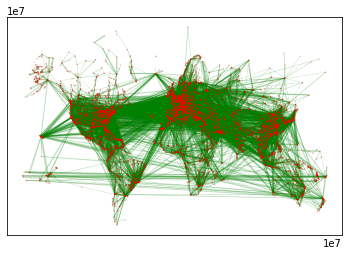

In [68]:
nx.draw_networkx_nodes(G = graph, pos = pos, node_list = graph.nodes(), node_color = 'r', alpha = 0.8,
                       node_size = [counts['total_flight'][s]*0.01 for s in graph.nodes()])
nx.draw_networkx_edges(G = graph, pos = pos, edge_color='g', width = routes_all['counts']*0.25, 
                       alpha=0.2, arrows = False)
plt.savefig("map_2.png", format = "png", dpi = 300)
plt.show()

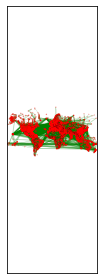

In [87]:
nx.draw_networkx_nodes(G = graph, pos = pos, node_list = graph.nodes(), node_color = 'r', alpha = 0.8,
                       node_size = [counts['total_flight'][s]*0.01 for s in graph.nodes()])
nx.draw_networkx_edges(G = graph, pos = pos, edge_color='g', width = routes_all['counts']*0.25, 
                       alpha=0.2, arrows = False)

m.drawcountries(linewidth = 0.1)
#m.drawstates(linewidth = 0.05)
#m.drawcoastlines(linewidth=0.1)
plt.tight_layout()

plt.savefig("map_3.png", format = "png", dpi = 300)
plt.show()

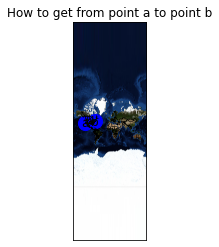

In [90]:
#https://stackoverflow.com/questions/19915266/drawing-a-graph-with-networkx-on-a-basemap
    
m = Basemap(
        projection='merc')

# position in decimal lat/lon
lats=[37.96,42.82]
lons=[-121.29,-73.95]
# convert lat and lon to map projection
mx,my=m(lons,lats)

# The NetworkX part
# put map projection coordinates in pos dictionary
G=nx.Graph()
G.add_edge('a','b')
pos={}
pos['a']=(mx[0],my[0])
pos['b']=(mx[1],my[1])
# draw
nx.draw_networkx(G,pos,node_size=200,node_color='blue')

# Now draw the map
m.drawcountries()
m.drawstates()
m.bluemarble()
plt.title('How to get from point a to point b')
plt.show()